In [52]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [53]:
# metadata 
# get sampleId, indId, group, batch, run from metadata tables
meta_file = '../snakemake/mage/filereport_read_run_PRJNA851328_tsv.txt'
meta = pd.read_csv(meta_file, sep='\t')

meta['sampleId'] = meta['indId'] = meta.experiment_alias.str.split('_', expand=True)[0]
meta['batch'] = meta.experiment_alias.str.split('_', expand=True)[1]


meta_file = '../snakemake/mage/sample_metadata_parsed.tsv'
df2 = pd.read_csv(meta_file, sep=' ', header=None)
df2.columns = ['sampleId', 'pop', 'continent', 'sex', 'sth', 'sth2']

meta = meta.merge(df2, how='left',
              on='sampleId')
meta['group'] = 1 # all the same group because we don't want to call sqtls separately for anything
meta[['sampleId', 'indId', 'group', 'batch', 'sex', 'pop', 'continent', 'experiment_alias']].head()
meta.head()

,run_accession,sample_accession,experiment_accession,study_accession,tax_id,scientific_name,instrument_platform,instrument_model,experiment_alias,fastq_bytes,...,bam_bytes,sampleId,indId,batch,pop,continent,sex,sth,sth2,group
0,SRR19762167,SAMN29221552,SRX15806983,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19704_batch11_rep1,1579585821;1583976496,...,NaN,NA19704,NA19704,batch11,ASW,AFR,female,SAMN29221552,SRS13499000,1
1,SRR19762172,SAMN29221523,SRX15806979,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19332_batch14_rep1,1969985537;1972458971,...,NaN,NA19332,NA19332,batch14,LWK,AFR,female,SAMN29221523,SRS13498996,1
2,SRR19762173,SAMN29221521,SRX15806977,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19317_batch15_rep1,1387073734;1388216521,...,NaN,NA19317,NA19317,batch15,LWK,AFR,male,SAMN29221521,SRS13498994,1
3,SRR19762174,SAMN29221520,SRX15806976,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19312_batch05_rep1,2814206811;2808461053,...,NaN,NA19312,NA19312,batch05,LWK,AFR,male,SAMN29221520,SRS13498993,1
4,SRR19762175,SAMN29221522,SRX15806978,PRJNA851328,9606,Homo sapiens,ILLUMINA,Illumina NovaSeq 6000,NA19323_batch11_rep1,1589064552;1592540862,...,NaN,NA19323,NA19323,batch11,LWK,AFR,female,SAMN29221522,SRS13498995,1


In [54]:
# regular gencode
df = pd.read_csv('../data/mage/v47_kallisto/matrix.abundance.tsv', sep='\t')

# sum up counts over all transcripts to get total assigned read count
df.set_index('transcript_id', inplace=True)
df = df.sum(axis=0)

In [55]:


# enhanced gencode
enh_df = pd.read_csv('../data/mage/enh_v47_kallisto/matrix.abundance.tsv', sep='\t')

# sum up counts over all transcripts to get total assigned read count
enh_df.set_index('transcript_id', inplace=True)
enh_df = enh_df.sum(axis=0)

df = df.to_frame()
enh_df = enh_df.to_frame()

df = df.rename({0: 'v47'}, axis=1)
enh_df = enh_df.rename({0: 'enh_v47'}, axis=1)

In [56]:
# merge 
l1 = len(df.index)
df = df.merge(enh_df, 
              how='inner',
              left_index=True,
              right_index=True)
l2 = len(df.index)
assert l1 == l2

In [57]:
df['diff'] = df['enh_v47']-df['v47']

In [58]:
# add metadata
df = df.merge(meta, 
              how='left',
              left_index=True,
              right_on='experiment_alias')
df.head()

,v47,enh_v47,diff,run_accession,sample_accession,experiment_accession,study_accession,tax_id,scientific_name,instrument_platform,...,bam_bytes,sampleId,indId,batch,pop,continent,sex,sth,sth2,group
0,2.487025e+07,2.507407e+07,203818.800975,SRR19762167,SAMN29221552,SRX15806983,PRJNA851328,9606,Homo sapiens,ILLUMINA,...,NaN,NA19704,NA19704,batch11,ASW,AFR,female,SAMN29221552,SRS13499000,1
1,2.944093e+07,2.978841e+07,347478.374569,SRR19762172,SAMN29221523,SRX15806979,PRJNA851328,9606,Homo sapiens,ILLUMINA,...,NaN,NA19332,NA19332,batch14,LWK,AFR,female,SAMN29221523,SRS13498996,1
2,2.011330e+07,2.027030e+07,157002.961184,SRR19762173,SAMN29221521,SRX15806977,PRJNA851328,9606,Homo sapiens,ILLUMINA,...,NaN,NA19317,NA19317,batch15,LWK,AFR,male,SAMN29221521,SRS13498994,1
3,4.238001e+07,4.271595e+07,335937.349840,SRR19762174,SAMN29221520,SRX15806976,PRJNA851328,9606,Homo sapiens,ILLUMINA,...,NaN,NA19312,NA19312,batch05,LWK,AFR,male,SAMN29221520,SRS13498993,1
4,2.393270e+07,2.410084e+07,168138.695071,SRR19762175,SAMN29221522,SRX15806978,PRJNA851328,9606,Homo sapiens,ILLUMINA,...,NaN,NA19323,NA19323,batch11,LWK,AFR,female,SAMN29221522,SRS13498995,1


<AxesSubplot:xlabel='continent', ylabel='diff'>

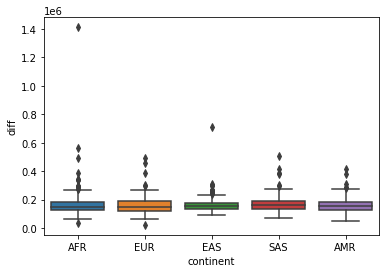

In [59]:
sns.boxplot(df, y='diff', x='continent')

In [60]:
# wilcoxon between eur and each other pop. 
# expectation is that gain is higher in non-eur populations

for c in df.continent.unique().tolist():
    if c != 'EUR':
        print()
        print(c)
        x = df.loc[df.continent == c, 'diff'].tolist() # hypothesis is that this is greater
        y = df.loc[df.continent == 'EUR', 'diff'].tolist()

        stat, pval = st.ranksums(x, y, alternative='greater')

        print(f'Wilcoxon rank-sum test statistic: {stat}')
        print(f'Wilcoxon rank-sum test pval: {pval}')


AFR
Wilcoxon rank-sum test statistic: 0.3807034412532147
Wilcoxon rank-sum test pval: 0.3517116575392295

EAS
Wilcoxon rank-sum test statistic: 0.7395226005924329
Wilcoxon rank-sum test pval: 0.22979486061046683

SAS
Wilcoxon rank-sum test statistic: 1.1781702073927633
Wilcoxon rank-sum test pval: 0.11936437863524785

AMR
Wilcoxon rank-sum test statistic: 0.4331044070438463
Wilcoxon rank-sum test pval: 0.33246946063412636


In [66]:
df[['diff', 'continent']].groupby('continent').median()

,diff
continent,
AFR,149791.801288
AMR,154323.077485
EAS,155730.277163
EUR,150635.374275
SAS,160616.820045


## What about when we compute a ratio instead?

In [62]:
df['ratio'] = df['enh_v47']/df['v47']

<AxesSubplot:xlabel='continent', ylabel='ratio'>

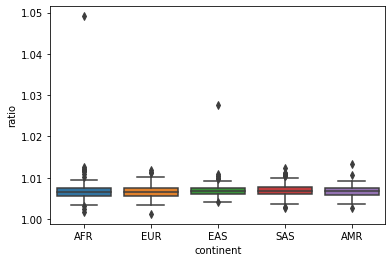

In [63]:
sns.boxplot(df, y='ratio', x='continent')

In [65]:
# wilcoxon between eur and each other pop. 
# expectation is that gain is higher in non-eur populations

for c in df.continent.unique().tolist():
    if c != 'EUR':
        print()
        print(c)
        x = df.loc[df.continent == c, 'ratio'].tolist() # hypothesis is that this is greater
        y = df.loc[df.continent == 'EUR', 'ratio'].tolist()

        stat, pval = st.ranksums(x, y, alternative='greater')

        print(f'Wilcoxon rank-sum test statistic: {stat}')
        print(f'Wilcoxon rank-sum test pval: {pval}')


AFR
Wilcoxon rank-sum test statistic: -0.2095699231898706
Wilcoxon rank-sum test pval: 0.5829983219264463

EAS
Wilcoxon rank-sum test statistic: 1.0707798316016053
Wilcoxon rank-sum test pval: 0.1421342187275949

SAS
Wilcoxon rank-sum test statistic: 1.3634170953476004
Wilcoxon rank-sum test pval: 0.08637554816906035

AMR
Wilcoxon rank-sum test statistic: -0.040022849495800976
Wilcoxon rank-sum test pval: 0.5159625451890407


In [67]:
df[['ratio', 'continent']].groupby('continent').median()

,ratio
continent,
AFR,1.006545
AMR,1.006680
EAS,1.006782
EUR,1.006659
SAS,1.006806


In [ ]:
## What about comparing the two 